In [1]:
import torch
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_data(file_path: str) -> tuple:
    """데이터를 불러오는 함수
    Args:
        file_path (str): 데이터 파일의 경로
    Returns:
        X_train, y_train, X_test, y_test
    """
    data = pandas.read_csv(file_path)
    # data = data.astype({'G(mg/dL)':'int'})
    X = data.drop('G(mg/dL)', axis=1).values
    y = data['G(mg/dL)'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return torch.tensor(X_train, dtype=torch.float32), \
        torch.tensor(y_train, dtype=torch.float32), \
        torch.tensor(X_test, dtype=torch.float32), \
        torch.tensor(y_test, dtype=torch.float32)


# 데이터 불러오기
data_S1 = load_data('data/data_S1.csv')
data_S2 = load_data('data/data_S2.csv')
data_S3 = load_data('data/data_S3.csv')

In [2]:
import torch
from torch import onnx
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from model import MLP, Conv1DModel, LinearRegressionModel

batch_size = 32
num_epochs = 200
learning_rate = 0.001

train_loader_S1 = DataLoader(TensorDataset(data_S1[0].unsqueeze(1), data_S1[1]), batch_size=batch_size, shuffle=True)
train_loader_S2 = DataLoader(TensorDataset(data_S2[0].unsqueeze(1), data_S2[1]), batch_size=batch_size, shuffle=True)
train_loader_S3 = DataLoader(TensorDataset(data_S3[0].unsqueeze(1), data_S3[1]), batch_size=batch_size, shuffle=True)

def train_model(model, train_loader, num_epochs, learning_rate, name:str):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    epoch_losses = []
    for epoch in tqdm(range(num_epochs), desc=f'Train {name}'):
        total_loss = 0
        total_batches = 0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            with torch.set_grad_enabled(True):
                y_hat = model(X)
                loss = criterion(y_hat.squeeze(), y)
                total_loss += loss.item()
                total_batches += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss = total_loss / total_batches
        epoch_losses.append(epoch_loss)
    torch.save(model.state_dict(), f'property/{name}.pt')
    onnx.export(model, X.to(device), f'property/{name}.onnx')
    return epoch_losses

model_mlp_S1 = MLP(5)
model_mlp_S2 = MLP(5)
model_mlp_S3 = MLP(5)
losses_mlp_S1 = train_model(model_mlp_S1, train_loader_S1, num_epochs, learning_rate, 'mlp_S1')
losses_mlp_S2 = train_model(model_mlp_S2, train_loader_S2, num_epochs, learning_rate, 'mlp_S2')
losses_mlp_S3 = train_model(model_mlp_S3, train_loader_S3, num_epochs, learning_rate, 'mlp_S3')

model_conv1d_S1 = Conv1DModel(1, 2)
model_conv1d_S2 = Conv1DModel(1, 2)
model_conv1d_S3 = Conv1DModel(1, 2)
losses_conv1d_S1 = train_model(model_conv1d_S1, train_loader_S1, num_epochs, learning_rate, 'conv1d_S1')
losses_conv1d_S2 = train_model(model_conv1d_S2, train_loader_S2, num_epochs, learning_rate, 'conv1d_S2')
losses_conv1d_S3 = train_model(model_conv1d_S3, train_loader_S3, num_epochs, learning_rate, 'conv1d_S3')

model_linear_S1 = LinearRegressionModel(5, 1, "sum")
model_linear_S2 = LinearRegressionModel(5, 1, "sum")
model_linear_S3 = LinearRegressionModel(5, 1, "sum")
losses_linear_S1 = train_model(model_linear_S1, train_loader_S1, num_epochs, learning_rate, 'linear_S1')
losses_linear_S2 = train_model(model_linear_S2, train_loader_S2, num_epochs, learning_rate, 'linear_S2')
losses_linear_S3 = train_model(model_linear_S3, train_loader_S3, num_epochs, learning_rate, 'linear_S3')

Train conv1d_S1: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.20it/s]
C:\Work\CGM\ETRI_CGM_Analysis_ModelDev\JaeseongArea\model\_1d_conv_net.py:28: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  x = functional.avg_pool1d(x, kernel_size=int(x.size(dim=2)))
Train linear_S3: 100%|███████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  8.04it/s]


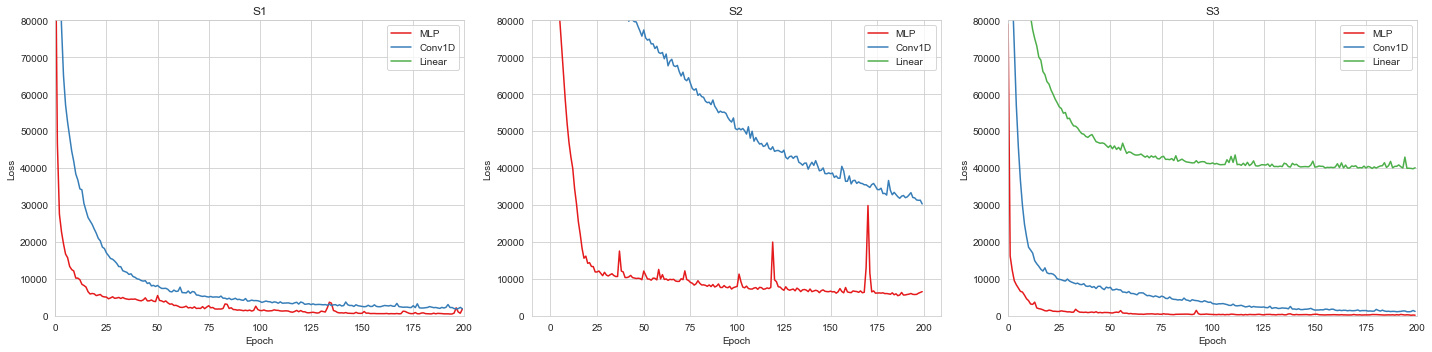

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('Set1')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.plot(losses_mlp_S1, label='MLP')
ax1.plot(losses_conv1d_S1, label='Conv1D')
ax1.plot(losses_linear_S1, label='Linear')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('S1')
ax1.set_ylim(0, 8E4)
ax1.set_xlim(0, 200)

ax2.plot(losses_mlp_S2, label='MLP')
ax2.plot(losses_conv1d_S2, label='Conv1D')
ax2.plot(losses_linear_S2, label='Linear')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('S2')
ax2.set_ylim(0, 8E4)
ax3.set_xlim(0, 200)

ax3.plot(losses_mlp_S3, label='MLP')
ax3.plot(losses_conv1d_S3, label='Conv1D')
ax3.plot(losses_linear_S3, label='Linear')
ax3.legend()
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_title('S3')
ax3.set_ylim(0, 8E4)
ax3.set_xlim(0, 200)

plt.tight_layout()
plt.show()

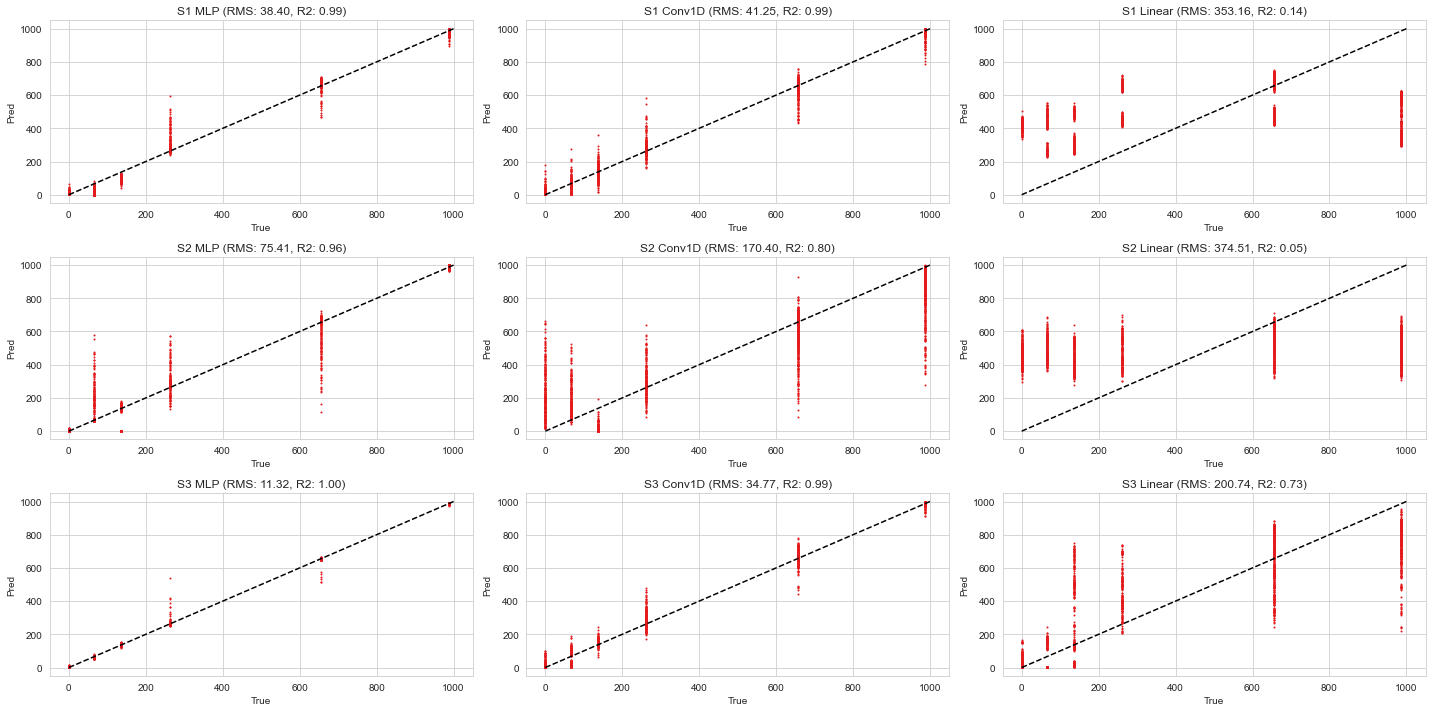

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
from sklearn.metrics import mean_squared_error, r2_score


def model_infer(model, loder) -> tuple:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in loder:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            y_pred.append(y_hat.cpu().numpy())
            y_true.append(y.cpu().numpy())
    y_pred = numpy.concatenate(y_pred)
    y_true = numpy.concatenate(y_true)
    rms = numpy.sqrt(mean_squared_error(y_true, y_pred.squeeze()))
    r2 = r2_score(y_true, y_pred.squeeze())
    return y_pred, y_true, rms, r2

sns.set_style('whitegrid')
sns.set_palette('Set1')

fig, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(20, 10))
y_pred, y_true, rms, r2 = model_infer(model_mlp_S1, train_loader_S1)
ax1[0].scatter(y_true, y_pred, s=1, label='MLP')
ax1[0].plot([0, 1000], [0, 1000], 'k--')
ax1[0].set_xlabel('True')
ax1[0].set_ylabel('Pred')
ax1[0].set_title(f'S1 MLP (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(model_conv1d_S1, train_loader_S1)
ax1[1].scatter(y_true, y_pred, s=1, label='Conv1D')
ax1[1].plot([0, 1000], [0, 1000], 'k--')
ax1[1].set_xlabel('True')
ax1[1].set_ylabel('Pred')
ax1[1].set_title(f'S1 Conv1D (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(model_linear_S1, train_loader_S1)
ax1[2].scatter(y_true, y_pred, s=1, label='Linear')
ax1[2].plot([0, 1000], [0, 1000], 'k--')
ax1[2].set_xlabel('True')
ax1[2].set_ylabel('Pred')
ax1[2].set_title(f'S1 Linear (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(model_mlp_S2, train_loader_S2)
ax2[0].scatter(y_true, y_pred, s=1, label='MLP')
ax2[0].plot([0, 1000], [0, 1000], 'k--')
ax2[0].set_xlabel('True')
ax2[0].set_ylabel('Pred')
ax2[0].set_title(f'S2 MLP (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(model_conv1d_S2, train_loader_S2)
ax2[1].scatter(y_true, y_pred, s=1, label='Conv1D')
ax2[1].plot([0, 1000], [0, 1000], 'k--')
ax2[1].set_xlabel('True')
ax2[1].set_ylabel('Pred')
ax2[1].set_title(f'S2 Conv1D (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(model_linear_S2, train_loader_S2)
ax2[2].scatter(y_true, y_pred, s=1, label='Linear')
ax2[2].plot([0, 1000], [0, 1000], 'k--')
ax2[2].set_xlabel('True')
ax2[2].set_ylabel('Pred')
ax2[2].set_title(f'S2 Linear (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(model_mlp_S3, train_loader_S3)
ax3[0].scatter(y_true, y_pred, s=1, label='MLP')
ax3[0].plot([0, 1000], [0, 1000], 'k--')
ax3[0].set_xlabel('True')
ax3[0].set_ylabel('Pred')
ax3[0].set_title(f'S3 MLP (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(model_conv1d_S3, train_loader_S3)
ax3[1].scatter(y_true, y_pred, s=1, label='Conv1D')
ax3[1].plot([0, 1000], [0, 1000], 'k--')
ax3[1].set_xlabel('True')
ax3[1].set_ylabel('Pred')
ax3[1].set_title(f'S3 Conv1D (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(model_linear_S3, train_loader_S3)
ax3[2].scatter(y_true, y_pred, s=1, label='Linear')
ax3[2].plot([0, 1000], [0, 1000], 'k--')
ax3[2].set_xlabel('True')
ax3[2].set_ylabel('Pred')
ax3[2].set_title(f'S3 Linear (RMS: {rms:.2f}, R2: {r2:.2f})')

plt.tight_layout()
plt.show()

In [5]:
import pandas
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_data(file_path: str) -> tuple:
    data = pandas.read_csv(file_path)
    X = data.drop('G(mg/dL)', axis=1).values
    y = data['G(mg/dL)'].values

    scaler = StandardScaler()
    X_data = scaler.fit_transform(X)
    
    return data, torch.tensor(X_data, dtype=torch.float32), \
        torch.tensor(y, dtype=torch.float32)

def model_infer_data(model, loder) -> tuple:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    y_pred = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in loder:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            y_pred.append(y_hat.cpu().numpy())
    y_pred = numpy.concatenate(y_pred).squeeze().tolist()
    return y_pred

origin1, dataX1, dataY1 = load_data('data/data_S1.csv')
origin2, dataX2, dataY2 = load_data('data/data_S2.csv')
origin3, dataX3, dataY3 = load_data('data/data_S3.csv')

loader1 = DataLoader(TensorDataset(dataX1.unsqueeze(1), dataY1), batch_size=1, shuffle=False)
loader2 = DataLoader(TensorDataset(dataX2.unsqueeze(1), dataY2), batch_size=1, shuffle=False)
loader3 = DataLoader(TensorDataset(dataX3.unsqueeze(1), dataY3), batch_size=1, shuffle=False)

y_pred_mpl1 = model_infer_data(model_mlp_S1, loader1)
y_pred_mpl2 = model_infer_data(model_mlp_S2, loader2)
y_pred_mpl3 = model_infer_data(model_mlp_S3, loader3)

y_pred_conv1 = model_infer_data(model_conv1d_S1, loader1)
y_pred_conv2 = model_infer_data(model_conv1d_S2, loader2)
y_pred_conv3 = model_infer_data(model_conv1d_S3, loader3)

y_pred_linear1 = model_infer_data(model_linear_S1, loader1)
y_pred_linear2 = model_infer_data(model_linear_S2, loader2)
y_pred_linear3 = model_infer_data(model_linear_S3, loader3)

df1 = pandas.DataFrame(origin1, columns=["G(mg/dL)","LD Temp","LD123_Bias_Av","mPD_dS","T-rPD_dS","R-rPD_dS"])
cols = list(df1.columns)
cols = cols[1:] + cols[:1]
df1 = df1[cols]
df1['G MPL(mg/dL)'] = y_pred_mpl1
df1['G Conv1D(mg/dL)'] = y_pred_conv1
df1['G Linear(mg/dL)'] = y_pred_linear1

df2 = pandas.DataFrame(origin2, columns=["G(mg/dL)","LD Temp","LD123_Bias_Av","mPD_dS","T-rPD_dS","R-rPD_dS"])
cols = list(df2.columns)
cols = cols[1:] + cols[:1]
df2 = df2[cols]
df2['G MPL(mg/dL)'] = y_pred_mpl2
df2['G Conv1D(mg/dL)'] = y_pred_conv2
df2['G Linear(mg/dL)'] = y_pred_linear2

df3 = pandas.DataFrame(origin3, columns=["G(mg/dL)","LD Temp","LD123_Bias_Av","mPD_dS","T-rPD_dS","R-rPD_dS"])
cols = list(df3.columns)
cols = cols[1:] + cols[:1]
df3 = df3[cols]
df3['G MPL(mg/dL)'] = y_pred_mpl3
df3['G Conv1D(mg/dL)'] = y_pred_conv3
df3['G Linear(mg/dL)'] = y_pred_linear3


df1 = df1.sample(frac=1)
df2 = df2.sample(frac=1)
df3 = df3.sample(frac=1)

In [6]:
df1.head()

,LD Temp,LD123_Bias_Av,mPD_dS,T-rPD_dS,R-rPD_dS,G(mg/dL),G MPL(mg/dL),G Conv1D(mg/dL),G Linear(mg/dL)
1487,26.906,13.187,978.046097,1153.920540,328.207230,987.185070,985.945984,993.699402,585.923462
1830,26.853,13.200,978.078094,1151.697839,327.732429,987.185070,985.492676,993.579651,585.986511
1040,26.853,13.200,977.855377,1424.644203,329.056000,655.807163,670.167725,694.266663,713.624878
1540,26.906,13.160,978.071837,1153.720244,328.129982,987.185070,985.277588,988.141541,570.684143
3056,26.853,13.100,981.846565,1310.530716,334.120154,987.185070,989.230225,995.043884,341.800507


In [7]:
df2.head()

,LD Temp,LD123_Bias_Av,mPD_dS,T-rPD_dS,R-rPD_dS,G(mg/dL),G MPL(mg/dL),G Conv1D(mg/dL),G Linear(mg/dL)
385,26.906,0.5,0.002861,789.868991,183.138780,135.994774,3.452136e-15,0.000027,479.368103
552,26.906,0.5,-0.006131,1082.571810,183.898455,261.667178,2.759521e+02,338.470367,559.272034
631,26.906,0.5,0.023842,1102.383294,183.127327,655.807163,6.706630e+02,571.099060,524.098450
875,26.853,0.5,0.027021,1103.009463,182.873014,655.807163,6.698632e+02,636.302124,526.790649
3175,26.906,0.4,0.020027,873.898485,183.525978,135.994774,1.236883e+02,3.645533,398.633911


In [8]:
df3.head()

,LD Temp,LD123_Bias_Av,mPD_dS,T-rPD_dS,R-rPD_dS,G(mg/dL),G MPL(mg/dL),G Conv1D(mg/dL),G Linear(mg/dL)
187,26.906,0.5,0.019074,1272.492767,1386.174721,65.699357,59.630074,32.294292,2.884638
162,26.960,0.5,-0.023843,1274.872299,1383.070163,65.699357,51.189510,0.611417,1.194749
1501,26.906,0.5,0.006131,1048.258096,1420.160556,987.185070,986.798584,989.111938,866.596924
921,26.906,0.5,0.022253,1204.663231,1415.728514,655.807163,654.690125,687.022461,756.523193
1153,26.906,0.5,-0.006358,1205.963346,1417.484203,655.807163,655.160278,731.393188,805.006653
